In [ ]:
#!/usr/bin/env python
# coding: utf-8

In[1]:

In [1]:
from pathlib import Path

In [2]:
import os
from pathlib import Path
import argparse

In [3]:
import torch
import tqdm
import yaml
from attrdict import AttrDict

In [4]:
from modules.comp.comp_d_net_pl import *
from modules.mono.depth_net_pl import *
from modules.mv.mv_depth_net_pl import *
from utils.data_utils import *
from utils.localization_utils import *

/cluster/home/wueestm/anaconda3/envs/f3loc/lib/python3.8/site-packages/torch/cuda/__init__.py:619: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [5]:
from torch.utils.data import DataLoader
import lightning as Lightning

In[2]:

In [6]:
net_type = "d"#"comp"#

dataset = "gibson_f"<br>
#dataset_path = "/cluster/scratch/wueestm/gibson/Gibson_Floorplan_Localization_Dataset"<br>
dataset_path= "/cluster/project/cvg/data/gibson/Gibson_Floorplan_Localization_Dataset"

In [7]:
dataset = "hge_customized_complete" #"hge_customized_cropped"
dataset_path = "/cluster/project/cvg/data/lamar/HGE_customized_complete" #"/cluster/project/cvg/data/lamar/HGE_customized_cropped"

In[3]:

get device

In [8]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("======= USING DEVICE : ", device, " =======")

======= USING DEVICE :  cpu  =======


In[4]:

parameters

In [9]:
L = 0  # number of the source frames
D = 128  # number of depth planes
d_min = 0.1  # minimum depth
d_max = 15.0  # maximum depth
d_hyp = -0.2  # depth transform (uniform sampling in d**d_hyp)
#F_W = 3 / 8  # camera intrinsic, focal length / image width
#trans_thresh = 0.005  # translation threshold (variance) if using comp_s

In [10]:
shape_loss_weight=40#1

In[5]:

In [11]:
add_rp = (
    True  # whether use roll and pitch angle augmentation, only used in training
)
roll = 0.00001  # maximum roll augmentation in radian
pitch = 0.00001  # maximum pitch augmentation in radian

In[6]:

paths

In [12]:
dataset_dir = os.path.join(dataset_path, dataset)
depth_dir = dataset_dir
#log_dir = ckpt_path
desdf_path = os.path.join(dataset_path, "desdf")

In [13]:
if (net_type == "d") & ((dataset == "hge_customized_cropped") or (dataset =="hge_customized_complete")):
    depth_suffix = "depth90"
elif net_type == "d":
    depth_suffix = "depth40"
else:
    depth_suffix = "depth160"

In[7]:

instantiate dataset

In [14]:
split_file = os.path.join(dataset_dir, "split.yaml")
with open(split_file, "r") as f:
    split = AttrDict(yaml.safe_load(f))

In[8]:

Define data

In [15]:
train_dataset = GridSeqDataset_hge_customized_cropped_gravity_align(
    dataset_dir,
    split.train,
    L=L,
    depth_dir=depth_dir,
    depth_suffix=depth_suffix,
    add_rp=add_rp,
    roll=roll,
    pitch=pitch,
)

self.scene_names:  ('ios_2022-01-12_15.15.53_000', 'ios_2022-01-18_17.05.03_000', 'ios_2022-01-20_16.52.33_001', 'ios_2022-01-25_14.34.24_002', 'ios_2022-01-25_14.57.49_000', 'ios_2022-01-25_15.13.54_000', 'ios_2022-06-13_10.45.07_000', 'ios_2022-06-13_15.59.36_000', 'ios_2022-06-14_17.12.28_000', 'ios_2022-06-30_15.55.53_000', 'ios_2022-07-01_15.18.09_000', 'ios_2022-07-01_15.58.10_000')
scene:  ios_2022-01-12_15.15.53_000
scene:  ios_2022-01-18_17.05.03_000
scene:  ios_2022-01-20_16.52.33_001
scene:  ios_2022-01-25_14.34.24_002
scene:  ios_2022-01-25_14.57.49_000
scene:  ios_2022-01-25_15.13.54_000
scene:  ios_2022-06-13_10.45.07_000
scene:  ios_2022-06-13_15.59.36_000
scene:  ios_2022-06-14_17.12.28_000
scene:  ios_2022-06-30_15.55.53_000
scene:  ios_2022-07-01_15.18.09_000
scene:  ios_2022-07-01_15.58.10_000


In [16]:
val_dataset = GridSeqDataset_hge_customized_cropped_gravity_align(
    dataset_dir,
    split.val,
    L=L,
    depth_dir=depth_dir,
    depth_suffix=depth_suffix,
    add_rp=add_rp,
    roll=roll,
    pitch=pitch,
)

self.scene_names:  ('ios_2022-07-01_15.45.08_000', 'ios_2022-01-18_17.10.39_000')
scene:  ios_2022-07-01_15.45.08_000
scene:  ios_2022-01-18_17.10.39_000


In [17]:
test_dataset = GridSeqDataset_hge_customized_cropped_gravity_align(
    dataset_dir,
    split.test,
    L=L,
    depth_dir=depth_dir,
    depth_suffix=depth_suffix,
    add_rp=add_rp,
    roll=roll,
    pitch=pitch,
)

self.scene_names:  ('ios_2022-07-03_16.00.37_000',)
scene:  ios_2022-07-03_16.00.37_000


In[9]:

rain_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)

In [18]:
train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True)

In[10]:

al_dataloader = DataLoader(val_dataset, batch_size=8, shuffle=False)

In [19]:
val_dataloader = DataLoader(val_dataset, batch_size=4, shuffle=False)

In [20]:
train_dataset.__len__()

3820

ios_2022-06-14_17.12.28_000


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


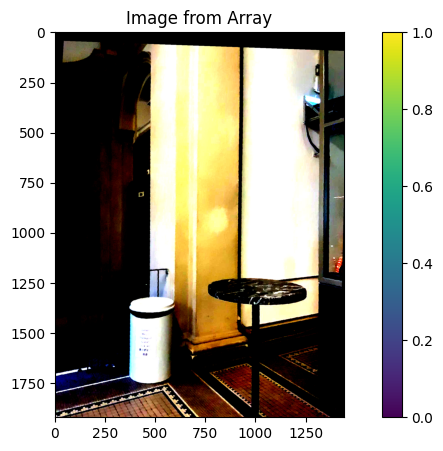

ios_2022-06-14_17.12.28_000


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


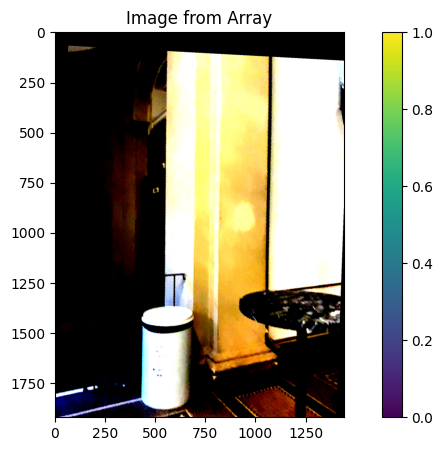

ios_2022-06-14_17.12.28_000


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


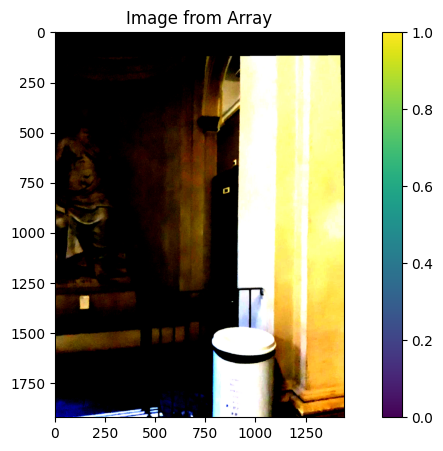

ios_2022-06-14_17.12.28_000


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


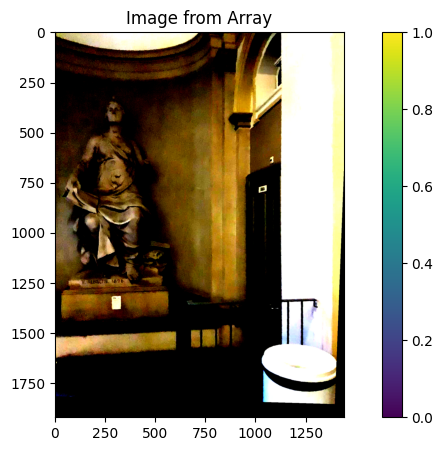

ios_2022-06-14_17.12.28_000


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


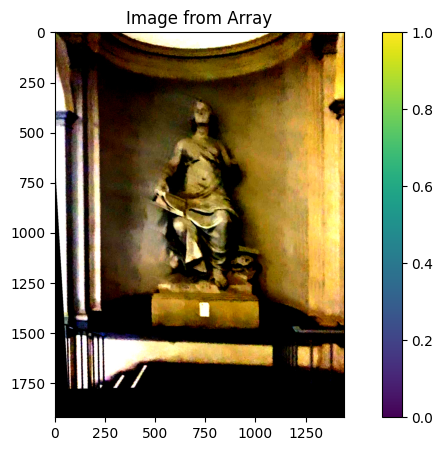

ios_2022-06-14_17.12.28_000


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


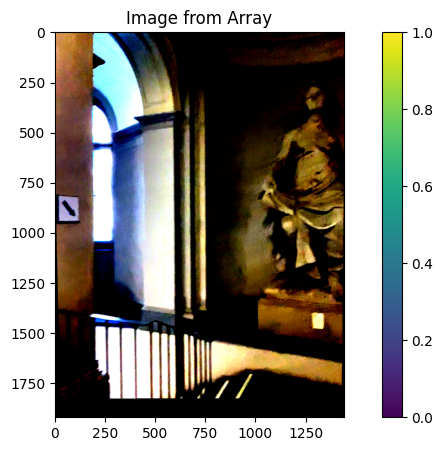

ios_2022-06-14_17.12.28_000


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


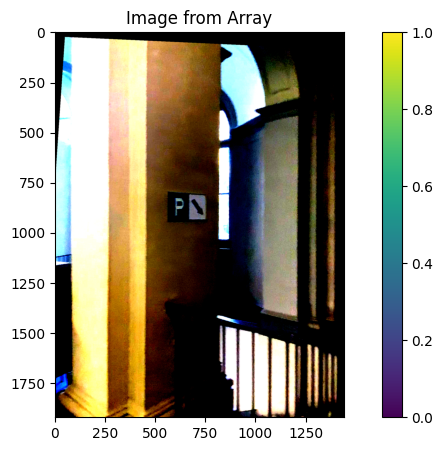

ios_2022-06-14_17.12.28_000


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


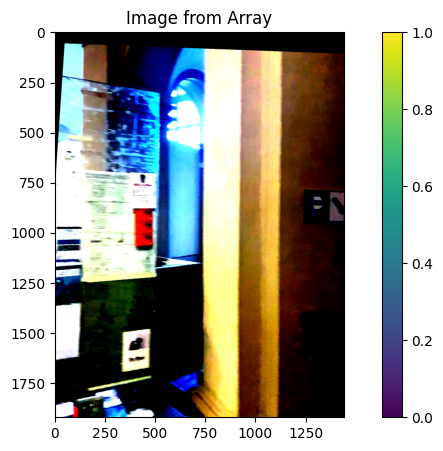

ios_2022-06-14_17.12.28_000


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


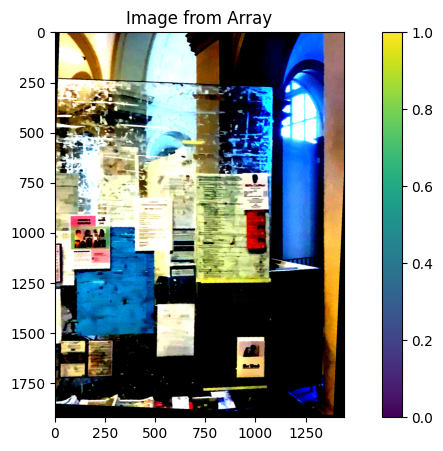

ios_2022-06-14_17.12.28_000


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


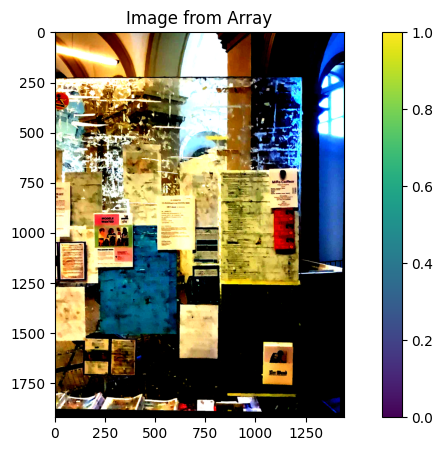

In [25]:
import matplotlib.pyplot as plt

for idx in range(2800,2810):
    ref_img = train_dataset[idx]['ref_img']
    print(train_dataset[idx]["scene_name"])
    plt.figure(figsize=(10, 5))
    plt.imshow(ref_img.transpose((1, 2, 0)))
    plt.colorbar()
    plt.title("Image from Array")
    plt.show()

In[11]:

Define model 

In [ ]:
model = depth_net_pl(shape_loss_weight=shape_loss_weight, lr=1e-3, d_min=d_min, d_max=d_max, d_hyp=d_hyp, D=D)

In[12]:

In [ ]:
from lightning.pytorch.loggers import TensorBoardLogger  # Import TensorBoardLogger

Setup TensorBoard logger

In [ ]:
logger = TensorBoardLogger("tb_logs", name="my_model")

In[13]:

Train the model<br>
rainer = Lightning.Trainer(max_steps=10, max_epochs=1, enable_checkpointing=True)<br>
rainer = Lightning.Trainer(max_epochs=100, enable_checkpointing=True, logger=logger)

In [ ]:
trainer = Lightning.Trainer(max_epochs=20, enable_checkpointing=False, logger=logger)
#trainer = Lightning.Trainer(max_steps=8, max_epochs=1, enable_checkpointing=True)
#trainer = Lightning.Trainer(max_epochs=8, enable_checkpointing=True)
#trainer = Lightning.Trainer(fast_dev_run=10, enable_checkpointing=True)
trainer.fit(model, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader)

In[ ]:

In[ ]:

In[ ]:

In[ ]: